In [1]:
import tqdm
import pandas as pd
import math
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pyproj

In [2]:
def filter_geographical_area(chunk, min_lat, max_lat, min_lon, max_lon):
    return chunk[
        (chunk['Latitude'] >= min_lat) & (chunk['Latitude'] <= max_lat) &
        (chunk['Longitude'] >= min_lon) & (chunk['Longitude'] <= max_lon)
    ]

In [5]:


def calculate_bounding_box_utm(center_lat, center_lon, distance_km):
    # Create a UTM projection centered around the specified point
    utm_zone = int((center_lon + 180) / 6) + 1
    utm_proj = pyproj.Proj(proj='utm', zone=utm_zone, ellps='WGS84')

    # Project the center point to UTM coordinates
    center_x, center_y = utm_proj(center_lon, center_lat)

    # Calculate bounding box in UTM coordinates
    min_x = center_x - distance_km * 1000
    max_x = center_x + distance_km * 1000
    min_y = center_y - distance_km * 1000
    max_y = center_y + distance_km * 1000

    # Convert back to latitude and longitude
    min_lon, min_lat = utm_proj(min_x, min_y, inverse=True)
    max_lon, max_lat = utm_proj(max_x, max_y, inverse=True)

    return min_lat, max_lat, min_lon, max_lon


In [6]:
file_path ='../data/aisdk-2023-08-01.csv'
chunk_size = 10000
input_csv = file_path
csv_reader = pd.read_csv(input_csv, chunksize=chunk_size, iterator=True)

# Aarhus Port coordinates
aarhus_port_lat = 56.1532
aarhus_port_lon = 10.2044

aarhus_df = pd.DataFrame()
# Calculate bounding box coordinates for a 10 km radius
min_lat, max_lat, min_lon, max_lon = calculate_bounding_box_utm(aarhus_port_lat, aarhus_port_lon, 20.0)
for i, chunk in enumerate(csv_reader):

    filtered_chunk = filter_geographical_area(chunk, min_lat, max_lat , min_lon, max_lon)
    aarhus_df = pd.concat([aarhus_df, filtered_chunk], ignore_index=True)
    if i % 100== 0:
        print(i * chunk_size, 'rows processed')

0 rows processed
1000000 rows processed
2000000 rows processed
3000000 rows processed
4000000 rows processed
5000000 rows processed
6000000 rows processed
7000000 rows processed
8000000 rows processed
9000000 rows processed
10000000 rows processed
11000000 rows processed


In [7]:
aarhus_df.shape

(100479, 26)

In [8]:
aarhus_df.columns

Index(['# Timestamp', 'Type of mobile', 'MMSI', 'Latitude', 'Longitude',
       'Navigational status', 'ROT', 'SOG', 'COG', 'Heading', 'IMO',
       'Callsign', 'Name', 'Ship type', 'Cargo type', 'Width', 'Length',
       'Type of position fixing device', 'Draught', 'Destination', 'ETA',
       'Data source type', 'A', 'B', 'C', 'D'],
      dtype='object')

In [25]:
aarhus_df['Data source type'].unique()

array(['AIS'], dtype=object)

In [22]:
def custom_mode(series):
    frecs = series.mode()
    if len(frecs) > 0 :
        ship_type = frecs[0]
        if ship_type == 'Undefined' and len(frecs) > 1:
            ship_type = frecs[1]
    else:
        ship_type = np.nan
    return ship_type

In [48]:
# aggregate by MMSI and '# Timestamp' by minute
# Latitude, Longitude into mean
# 'Type of mobile' into mode
# Heading into mode
# 'Navigational status' into mode
# 'ROT', 'SOG', 'COG' into mean
# IMO into first
# 'Ship type' into mode
# 'Length', 'Width' into first
# 'Draught' into mean
# 'Destination' into mode
# 'Cargo type' into mode
# data source type into first
# A, B,C,D into first
agg_functions = {
    'Latitude': 'mean',
    'Longitude': 'mean',
    'Type of mobile': custom_mode,
    'Heading': 'mean',
    'Navigational status': custom_mode,
    'ROT': 'mean',
    'SOG': 'mean',
    'COG': 'mean',
    'IMO': 'first',
    'Ship type': custom_mode,
    'Length': 'first',
    'Width': 'first',
    'Draught': 'mean',
    'Destination': custom_mode,
    'Cargo type': custom_mode,
    'Data source type': 'first',
    'A': 'first',
    'B': 'first',
    'C': 'first',
    'D': 'first',
    'Type of position fixing device': 'first',
    'Callsign' : 'first',
    'Name' : 'first',
    'ETA' : 'first'
}


In [31]:
aarhus_df['# Timestamp'] = pd.to_datetime(aarhus_df['# Timestamp'])


In [32]:
aarhus_df = aarhus_df.groupby(['MMSI', pd.Grouper(key='# Timestamp', freq='1min')]).agg(agg_functions).reset_index()

In [51]:
aarhus_df.MMSI.unique()

array([111219502, 111219504, 210359000, 211176580, 211209300, 211214470,
       211234760, 211238220, 211284500, 211304030, 211336340, 211355360,
       211494700, 211503920, 211527630, 211582340, 211603940, 211639430,
       211652850, 211655020, 211673700, 211674560, 211727450, 211733530,
       211749750, 211762600, 211794630, 211812840, 211819330, 211821010,
       211828320, 211838110, 211845370, 211853820, 211868590, 211891860,
       211895010, 219000175, 219001166, 219002416, 219002468, 219002973,
       219003249, 219003485, 219003513, 219004426, 219004888, 219005313,
       219005477, 219005916, 219006091, 219006999, 219007608, 219008177,
       219008585, 219010656, 219011104, 219011894, 219015161, 219015654,
       219015839, 219016571, 219017259, 219017787, 219018172, 219019713,
       219020242, 219020372, 219020587, 219020912, 219021559, 219021582,
       219021649, 219021695, 219021871, 219022199, 219022627, 219022728,
       219022852, 219022903, 219023562, 219023637, 

In [55]:
aarhus_df[aarhus_df['MMSI'] == 314438000]

,MMSI,# Timestamp,Latitude,Longitude,Type of mobile,Heading,Navigational status,ROT,SOG,COG,...,Cargo type,Data source type,A,B,C,D,Type of position fixing device,Callsign,Name,ETA
32535,314438000,2023-01-08 12:46:00,55.977304,10.498393,Class A,347.0,Under way using engine,0.0,11.900000,349.350000,...,NaN,AIS,78.0,12.0,6.0,6.0,GPS,8PAM7,WILSON THAMES,01/08/2023 16:00:00
32536,314438000,2023-01-08 12:47:00,55.979635,10.497597,Class A,348.0,Under way using engine,0.0,11.900000,349.750000,...,NaN,AIS,78.0,12.0,6.0,6.0,GPS,8PAM7,WILSON THAMES,01/08/2023 16:00:00
32537,314438000,2023-01-08 12:48:00,55.982844,10.496304,Class A,323.0,Under way using engine,NaN,11.491667,338.708333,...,NaN,AIS,78.0,12.0,6.0,6.0,GPS,8PAM7,WILSON THAMES,01/08/2023 16:00:00
32538,314438000,2023-01-08 12:49:00,55.985161,10.493891,Class A,318.0,Under way using engine,0.0,11.075000,322.750000,...,NaN,AIS,78.0,12.0,6.0,6.0,GPS,8PAM7,WILSON THAMES,01/08/2023 16:00:00
32539,314438000,2023-01-08 12:50:00,55.987708,10.490230,Class A,316.0,Under way using engine,0.0,11.080000,319.100000,...,NaN,AIS,78.0,12.0,6.0,6.0,GPS,8PAM7,WILSON THAMES,01/08/2023 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32821,314438000,2023-01-08 23:46:00,56.133833,10.292000,Class A,333.0,At anchor,0.0,0.000000,NaN,...,NaN,AIS,78.0,12.0,6.0,6.0,GPS,8PAM7,WILSON THAMES,01/08/2023 16:00:00
32822,314438000,2023-01-08 23:49:00,56.133833,10.292000,Class A,334.0,At anchor,0.0,0.100000,50.400000,...,NaN,AIS,78.0,12.0,6.0,6.0,GPS,8PAM7,WILSON THAMES,01/08/2023 16:00:00
32823,314438000,2023-01-08 23:52:00,56.133900,10.292143,Class A,328.0,At anchor,0.0,0.100000,69.400000,...,NaN,AIS,78.0,12.0,6.0,6.0,GPS,8PAM7,WILSON THAMES,01/08/2023 16:00:00
32824,314438000,2023-01-08 23:55:00,56.134000,10.292333,Class A,323.0,At anchor,0.0,0.100000,41.500000,...,NaN,AIS,78.0,12.0,6.0,6.0,GPS,8PAM7,WILSON THAMES,01/08/2023 16:00:00


In [11]:
aarhus_df['Ship type'].unique()

array(['Undefined', 'Passenger', 'Cargo', 'Sailing', 'Pleasure', 'Tug',
       'HSC', 'Pilot', 'Port tender', 'Military', 'Fishing', 'SAR',
       'Other', 'Tanker'], dtype=object)

In [43]:
def add_route(map,df,color_codes, ship_type = None,exclude_types = ['SAR'] ):
    
    mmsis = df['MMSI'].unique()

    for mmsi in mmsis:
        mmsi_df = df[df['MMSI'] == mmsi]
        frecs  = mmsi_df['Ship type'].mode()
        ship_type = frecs[0]
        if ship_type == 'Undefined' and len(frecs) > 1 :
            ship_type = frecs[1]
        color = color_codes[mmsi_df['Ship type'].iloc[0]]
        if ship_type not in exclude_types:
            # Convert latitude and longitude to map coordinates
            x, y = map(mmsi_df['Longitude'].values, mmsi_df['Latitude'].values)
            map.plot(x, y, marker=None,color = color, linewidth=2, alpha=0.3)


In [44]:
def plot_ais_df(ais_df, margin = 0.05):
    plt.figure(figsize=(20,20))

    map = Basemap(
        projection='merc',
        llcrnrlat=ais_df['Latitude'].min() - margin,
        urcrnrlat=ais_df['Latitude'].max() + margin,
        llcrnrlon=ais_df['Longitude'].min() - margin,
        urcrnrlon=ais_df['Longitude'].max() + margin, 
        resolution='h',
    )
    color_codes = {
        'Sailing': 'blue',
        'Pleasure': 'green',
        'Military': 'red',
        'Passenger': 'purple',
        'Tug': 'orange',
        'Port tender': 'brown',
        'Pilot': 'pink',
        'HSC': 'gray',
        'Cargo': 'cyan',
        'Undefined': 'magenta',
        'Other': 'yellow',
        'SAR': 'lime',
        'Fishing': 'teal',
        'Tanker': 'indigo',
        'Law enforcement' : 'olive'
    }

    ais_df[['MMSI','Ship type']] = ais_df[['MMSI','Ship type']].fillna(method='ffill').fillna(method='bfill')
    ais_df[['Latitude','Longitude']] = ais_df[['Latitude','Longitude']].interpolate(method='linear')


    # Draw a map background
    map.drawcoastlines()
    map.drawcountries()
    map.drawmapboundary(fill_color='white')
    add_route(map,ais_df,color_codes)

    legend_colors = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in color_codes.items()]
    plt.legend(handles=legend_colors, title='Ship Types', loc='upper left')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

/tmp/ipykernel_3012/3446888609.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ais_df[['MMSI','Ship type']] = ais_df[['MMSI','Ship type']].fillna(method='ffill').fillna(method='bfill')


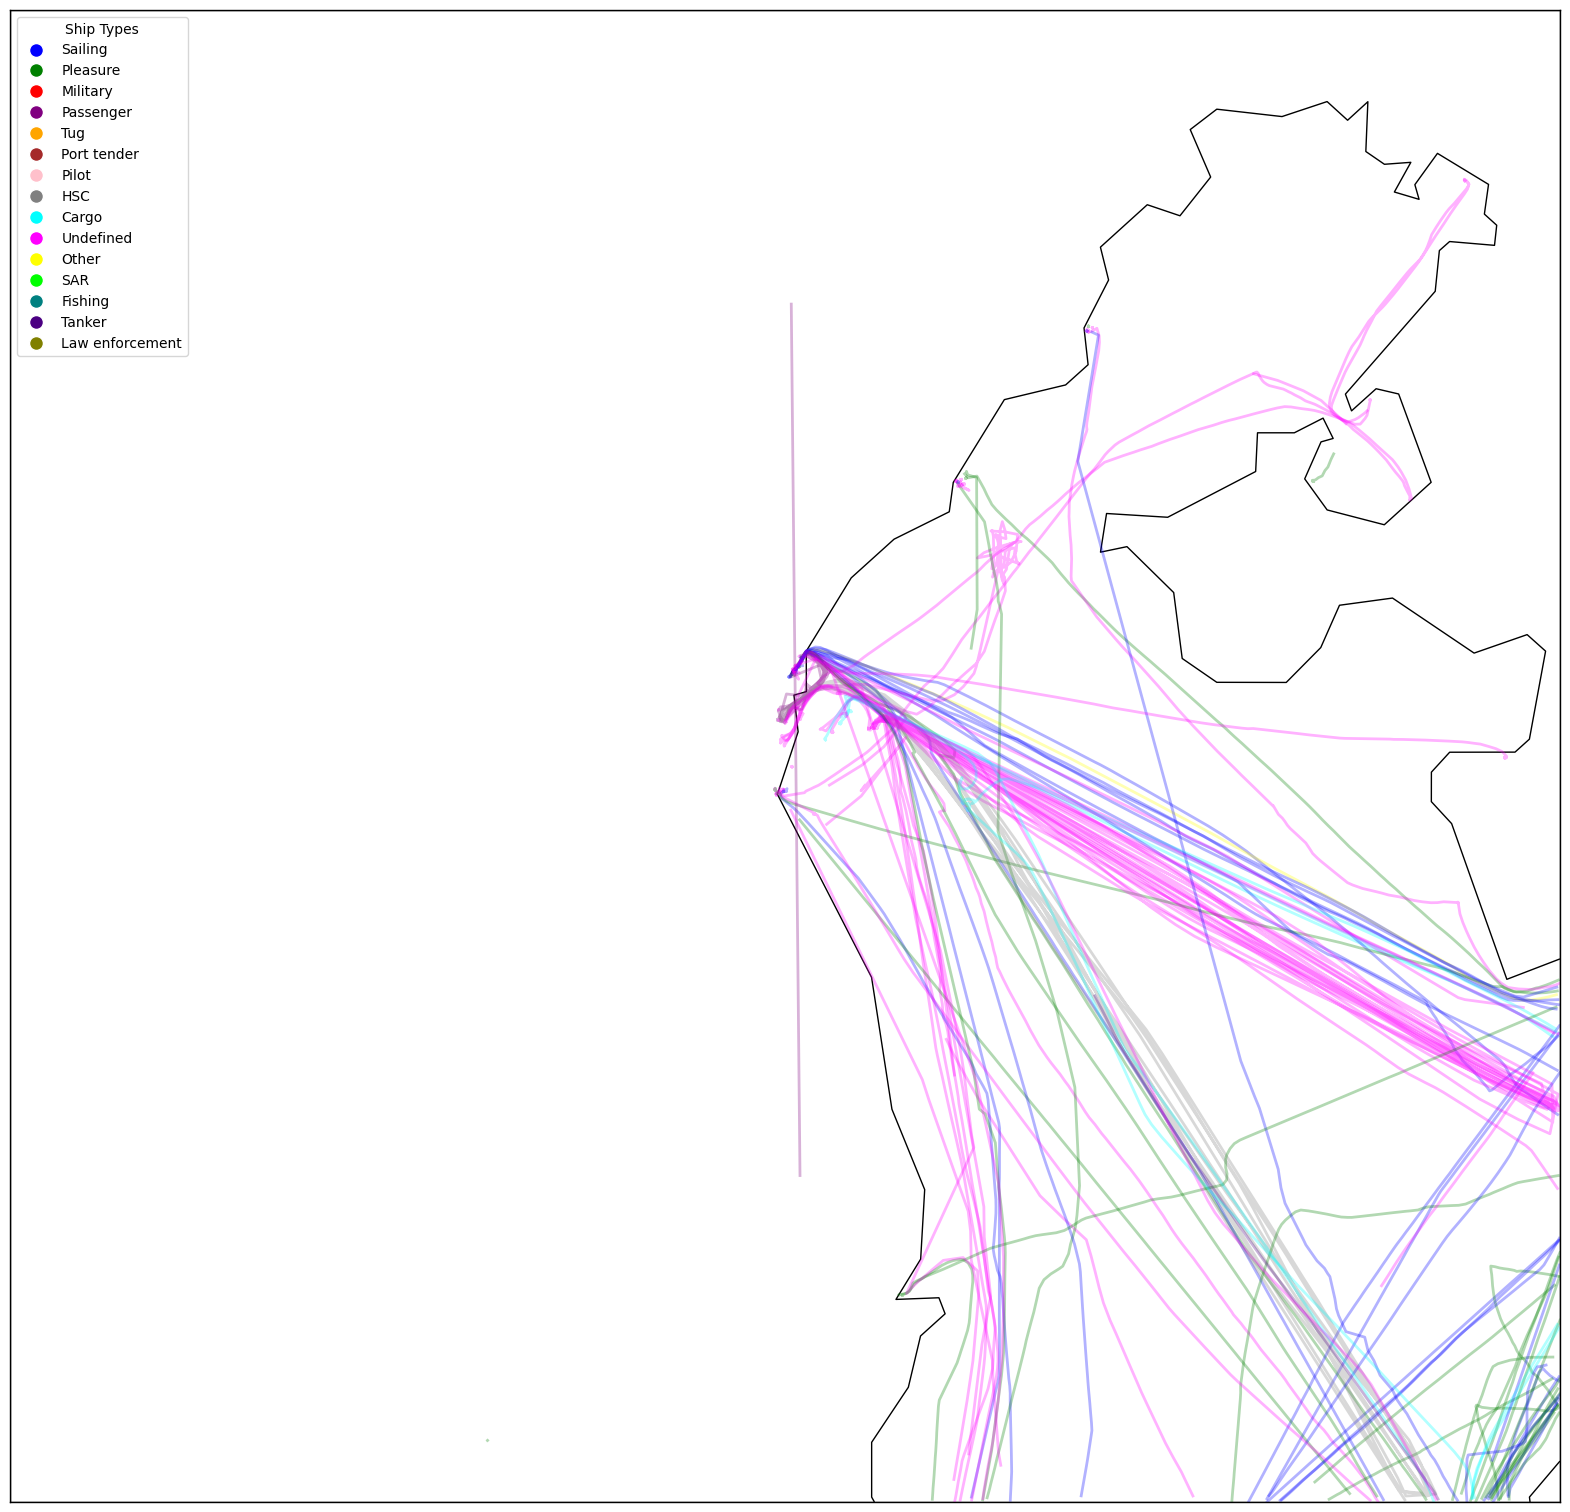

In [45]:
plot_ais_df(aarhus_df, margin= 0)

/tmp/ipykernel_3012/3446888609.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ais_df[['MMSI','Ship type']] = ais_df[['MMSI','Ship type']].fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_3012/3446888609.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ais_df[['MMSI','Ship type']] = ais_df[['MMSI','Ship type']].fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_3012/3446888609.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

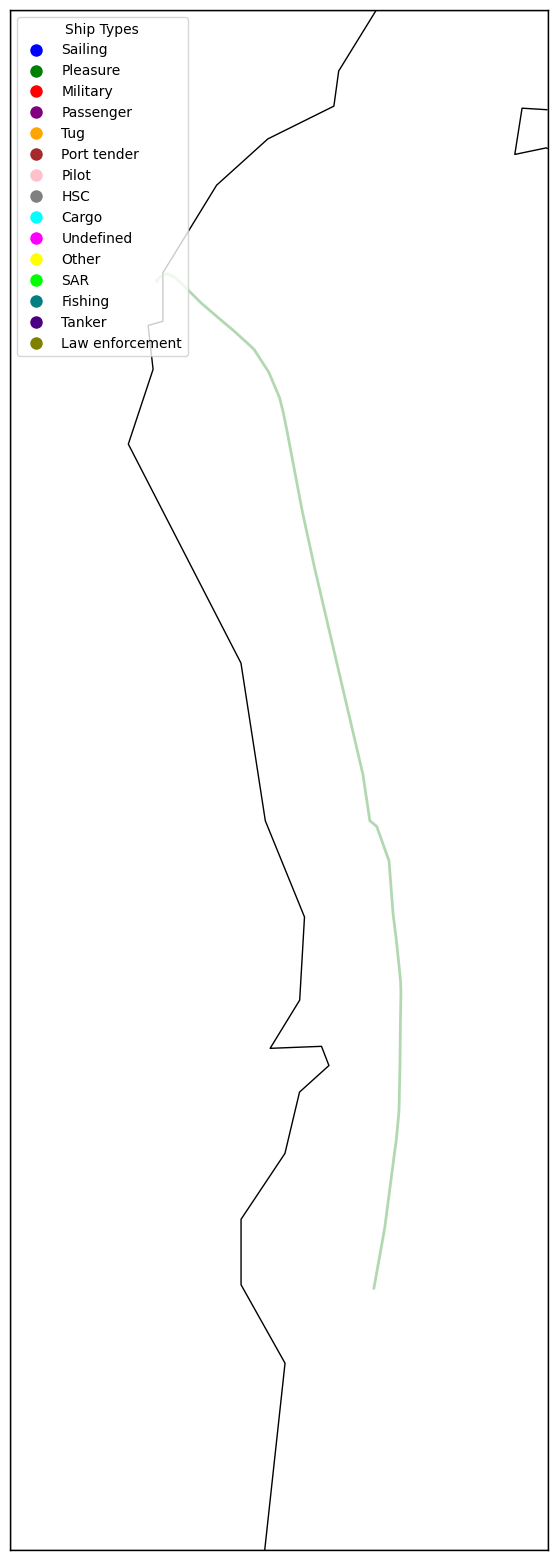

In [53]:
tr = aarhus_df[aarhus_df['MMSI'] == 244182630]
plot_ais_df(tr)

In [38]:
tr

,MMSI,# Timestamp,Latitude,Longitude,Type of mobile,Heading,Navigational status,ROT,SOG,COG,...,Cargo type,Data source type,A,B,C,D,Type of position fixing device,Callsign,Name,ETA
0,111219502,2023-01-08 08:52:00,56.103978,9.903321,Class A,NaN,Under way using engine,NaN,102.2,112.133333,...,NaN,AIS,1.0,19.0,2.0,3.0,GPS,Unknown,M 502,None
1,111219502,2023-01-08 08:53:00,56.090078,9.964468,Class A,NaN,Under way using engine,NaN,102.2,111.933333,...,NaN,AIS,1.0,19.0,2.0,3.0,GPS,Unknown,M 502,None
2,111219502,2023-01-08 08:54:00,56.074232,10.037226,Class A,NaN,Under way using engine,NaN,102.2,110.833333,...,NaN,AIS,1.0,19.0,2.0,3.0,GPS,Unknown,M 502,None
3,111219502,2023-01-08 08:55:00,56.058647,10.110415,Class A,NaN,Under way using engine,NaN,102.2,111.000000,...,NaN,AIS,1.0,19.0,2.0,3.0,GPS,Unknown,M 502,None
4,111219502,2023-01-08 08:56:00,56.043028,10.181994,Class A,NaN,Under way using engine,NaN,102.2,111.441379,...,NaN,AIS,1.0,19.0,2.0,3.0,GPS,Unknown,M 502,None
5,111219502,2023-01-08 08:57:00,56.027239,10.253712,Class A,NaN,Under way using engine,NaN,102.2,111.638710,...,NaN,AIS,1.0,19.0,2.0,3.0,GPS,Unknown,M 502,None
6,111219502,2023-01-08 08:58:00,56.010928,10.325989,Class A,NaN,Under way using engine,NaN,102.2,111.866667,...,NaN,AIS,1.0,19.0,2.0,3.0,GPS,Unknown,M 502,None
7,111219502,2023-01-08 08:59:00,55.994716,10.399017,Class A,NaN,Under way using engine,NaN,102.2,111.563333,...,NaN,AIS,1.0,19.0,2.0,3.0,GPS,Unknown,M 502,None
8,111219502,2023-01-08 09:00:00,55.981429,10.458806,Class A,NaN,Under way using engine,NaN,102.2,111.957895,...,NaN,AIS,1.0,19.0,2.0,3.0,GPS,Unknown,M 502,None
9,111219502,2023-01-08 10:28:00,56.094891,10.504565,Class A,NaN,Under way using engine,NaN,102.2,291.056000,...,NaN,AIS,1.0,19.0,2.0,3.0,GPS,0,M 502,None


/tmp/ipykernel_6206/2686864391.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ais_df = ais_df.fillna(method='ffill').fillna(method='bfill')


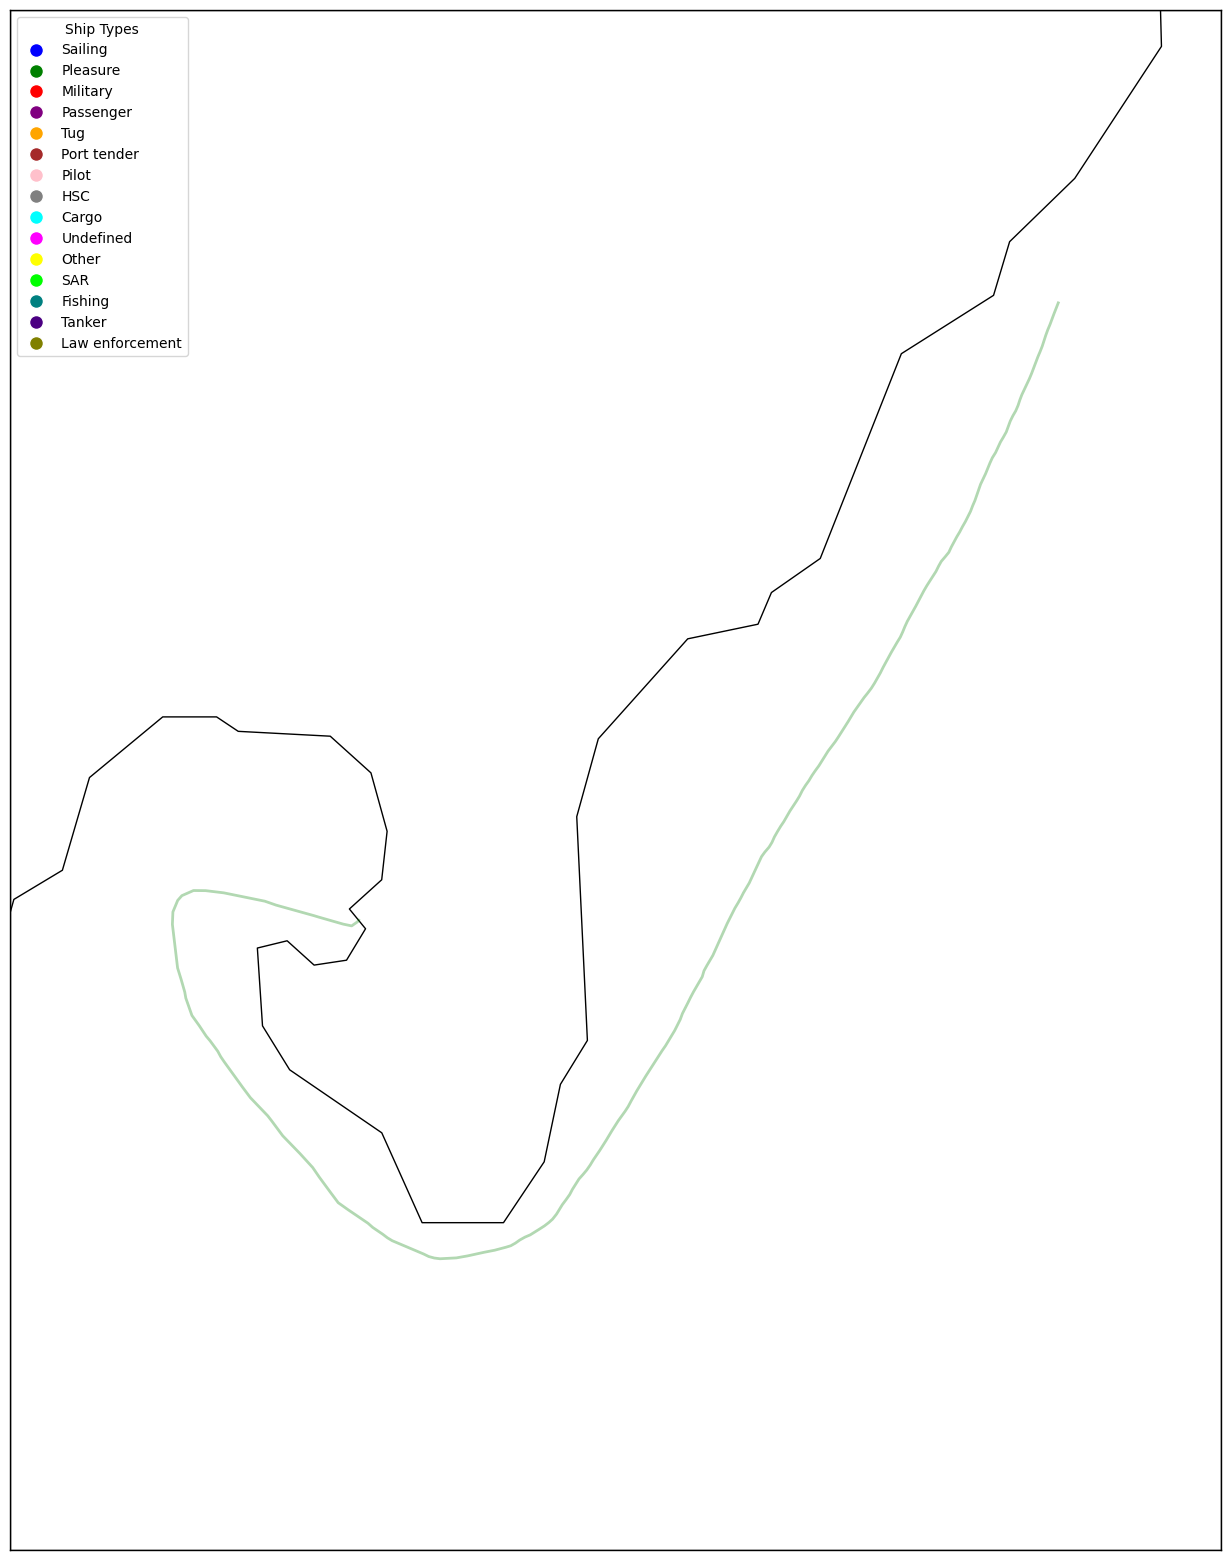

In [53]:
one_ship = aarhus_df[aarhus_df['MMSI'] == 211226110]
plot_ais_df(one_ship)

In [73]:
one_ship['# Timestamp'] = pd.to_datetime(one_ship['# Timestamp'])

agg_functions = {
    'MMSI': 'first',
    'Longitude': 'mean',
    'Latitude': 'mean',
    'Ship type': custom_mode  # Use the custom aggregation function
}

one_ship_agg = one_ship[['# Timestamp','MMSI','Longitude','Latitude','Ship type']].groupby(pd.Grouper(key='# Timestamp', freq='1Min')).agg(agg_functions)
#plot_ais_df(one_ship_agg)


/tmp/ipykernel_6206/3437152090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_ship['# Timestamp'] = pd.to_datetime(one_ship['# Timestamp'])


In [74]:
type(one_ship_agg.iloc[-2]['MMSI'])

numpy.float64

In [75]:
time_stamps  = one_ship['# Timestamp'].astype('datetime64[ns]')
for i,ts in enumerate(time_stamps):
    if i > 0:
        print(ts- time_stamps.iloc[i-1])

0 days 00:00:09
0 days 00:00:03
0 days 00:00:18
0 days 00:00:31
0 days 00:00:31
0 days 00:00:28
0 days 00:00:30
0 days 00:00:32
0 days 00:00:28
0 days 00:00:30
0 days 00:00:30
0 days 00:00:30
0 days 00:00:30
0 days 00:00:30
0 days 00:00:10
0 days 00:00:03
0 days 00:00:16
0 days 00:00:31
0 days 00:00:29
0 days 00:00:31
0 days 00:00:31
0 days 00:00:28
0 days 00:00:30
0 days 00:00:32
0 days 00:00:28
0 days 00:00:31
0 days 00:00:29
0 days 00:00:31
0 days 00:00:09
0 days 00:00:00
0 days 00:00:22
0 days 00:00:28
0 days 00:01:00
0 days 00:00:32
0 days 00:00:29
0 days 00:00:30
0 days 00:00:29
0 days 00:01:01
0 days 00:00:29
0 days 00:00:33
0 days 00:00:07
0 days 00:00:20
0 days 00:00:30
0 days 00:00:30
0 days 00:01:00
0 days 00:00:31
0 days 00:00:29
0 days 00:00:31
0 days 00:00:29
0 days 00:00:30
0 days 00:00:30
0 days 00:00:30
0 days 00:00:11
0 days 00:00:02
0 days 00:00:18
0 days 00:00:29
0 days 00:00:31
0 days 00:00:29
0 days 00:00:32
0 days 00:00:27
0 days 00:00:30
0 days 00:00:30
0 days 0

In [77]:
one_ship_agg[['MMSI','Shiptype']] = one_ship_agg[['MMSI','Shiptype']].fillna(method='ffill').fillna(method='bfill')
one_ship_agg[['Latitude','Longitude']] = one_ship_agg[['Latitude','Longitude']].interpolate(method='linear')


KeyError: "['Shiptype'] not in index"

In [81]:

one_ship_agg[['MMSI','Ship type']] = one_ship_agg[['MMSI','Ship type']].fillna(method='ffill').fillna(method='bfill')
one_ship_agg[['Latitude','Longitude']] = one_ship_agg[['Latitude','Longitude']].interpolate(method='linear')


/tmp/ipykernel_6206/2904575824.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  one_ship_agg[['MMSI','Ship type']] = one_ship_agg[['MMSI','Ship type']].fillna(method='ffill').fillna(method='bfill')


In [84]:
one_ship_agg.iloc[690:719]

,# Timestamp,MMSI,Longitude,Latitude,Ship type
690,2023-01-08 23:19:00,211226110.0,10.668713,56.193889,Pleasure
691,2023-01-08 23:20:00,211226110.0,10.668715,56.193891,Pleasure
692,2023-01-08 23:21:00,211226110.0,10.668716,56.193894,Pleasure
693,2023-01-08 23:22:00,211226110.0,10.668718,56.193896,Pleasure
694,2023-01-08 23:23:00,211226110.0,10.668720,56.193898,Pleasure
695,2023-01-08 23:24:00,211226110.0,10.668721,56.193901,Pleasure
696,2023-01-08 23:25:00,211226110.0,10.668723,56.193903,Pleasure
697,2023-01-08 23:26:00,211226110.0,10.668722,56.193904,Pleasure
698,2023-01-08 23:27:00,211226110.0,10.668722,56.193905,Pleasure
699,2023-01-08 23:28:00,211226110.0,10.668721,56.193905,Pleasure


/tmp/ipykernel_6206/2686864391.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ais_df = ais_df.fillna(method='ffill').fillna(method='bfill')


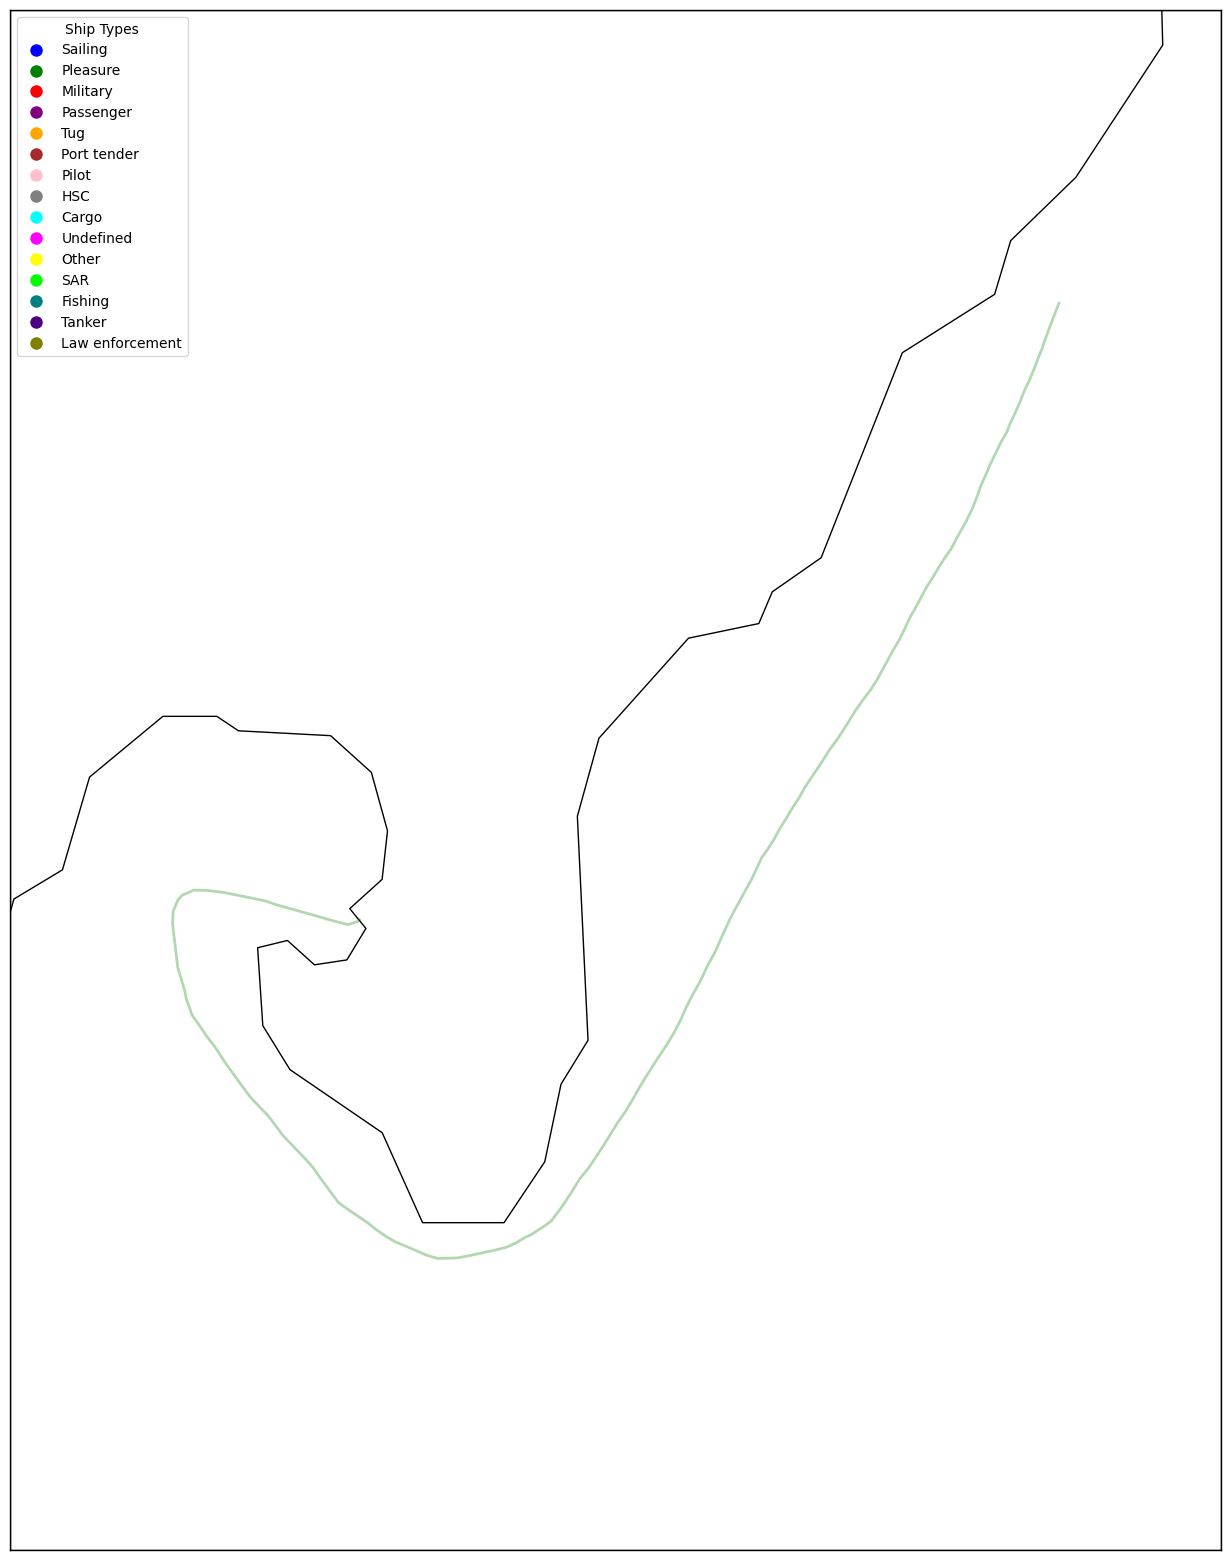

In [83]:
plot_ais_df(one_ship_agg)